In [1]:
import os
from enum import Enum

import PIL
import torch
from torchvision import transforms

from typing import List, Tuple

import pandas as pd
# import pytorch_lightning as pl
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [4]:
# Possible classes: fastmri + ixi, ixi, fastmri.

_CLASSNAMES = [
    "fastmrixi"
]

In [5]:
# Note: backbone is still ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [94]:
class DatasetSplit(Enum):
    TRAIN = "train"
    VAL = "val" # obsolete
    TEST = "test"

In [161]:
# Dataset class for both training and test datasets.
class FastmriIxiDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for FastMRI and IXI images (brain MRI)
    """

    def __init__(
        self,
        source,
        classname,
        resize=256,
        imagesize=224,
        split=DatasetSplit.TRAIN,
        train_val_split=1.0, # Obsolete
        **kwargs,
    ):
        """
        Args:
            source: [str]. Path to the FastmriIxi data folder.
            classname: [str or None]. Name of class (fastmri+ixi, fastmri, or ixi) to use. If None, the datasets
                       iterates over all available images.
            resize: [int]. (Square) Size the loaded image initially gets
                    resized to.
            imagesize: [int]. (Square) Size the resized loaded image gets
                       (center-)cropped to. # TODO NOT IMPLEMETED
            split: [enum-option]. Indicates if training or test split of the
                   data should be used. Has to be an option taken from
                   DatasetSplit, e.g. mvtec.DatasetSplit.TRAIN. Note that
                   mvtec.DatasetSplit.TEST will also load mask data.
        """
        super().__init__()
        self.source = source
        self.split = split
        self.classnames_to_use = [classname] if classname is not None else _CLASSNAMES
        self.train_val_split = train_val_split # Obsolete
        self.resize = resize
        self.imagesize = (3, imagesize, imagesize) # TODO this might mess up some transformation operations later.
        self.transform_std = IMAGENET_STD
        self.transform_mean = IMAGENET_MEAN

        self.pathologies = [
          'absent_septum',
          'artefacts',
          'craniatomy',
          'dural',
          'ea_mass',
          'edema',
          'encephalomalacia',
          'enlarged_ventricles',
          'intraventricular',
          'lesions',
          'mass',
          'posttreatment',
          'resection',
          'sinus',
          'wml',
          'other'
        ]
        self.imgpaths_per_class, self.data_to_iterate = self.get_image_data()

        # self.transform_img = [
        #     PIL.convert('RGB')
        #     transforms.,
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        # ]
        # self.transform_img = transforms.Compose(self.transform_img)

        # self.transform_mask = [
        #     transforms.Resize(resize),
        #     transforms.CenterCrop(imagesize),
        #     transforms.ToTensor(),
        # ]
        # self.transform_mask = transforms.Compose(self.transform_mask)



    def __getitem__(self, idx):
      classname, anomaly, image_path, mask_path = self.data_to_iterate[idx]
      ### Transforms ###
      # Open image
      image = PIL.Image.open(image_path).convert("L")
      # TODO: not do this in test data? if(anomaly!="good") ...
      # Pad to square
      image = transforms.Pad(((image.height - image.width) // 2, 0), fill=0)(image)
      # Resize
      image = image.resize((self.resize,self.resize), Image.BICUBIC)
      # TODO NO CROPPING ?
      # Transform to tensor
      image = transforms.ToTensor()(image)


      if self.split == DatasetSplit.TEST and mask_path is not None:
          mask = PIL.Image.open(mask_path).convert('L')
          # Transform (positive) mask
          mask = mask.resize((self.resize,self.resize), Image.NEAREST)
          # NO CROPPING
          mask = transforms.ToTensor()(mask)

      else:
          mask = torch.zeros([1, *image.size()[1:]]) # Create empty mask for good images

      return {
          "image": image,
          "mask": mask,
          "classname": classname,
          "anomaly": anomaly,
          "is_anomaly": int(anomaly != "good"),
          "image_name": "/".join(image_path.split("/")[-2:]), #TODO Rewrite this to match with new image names. As subdir structure of FastMRI and IXI different, this is not sufficient.
          "image_path": image_path,
      }

    def __len__(self):
      return len(self.data_to_iterate)


# imgpaths_per_class: dict of dicts. [class], [anomaly]
# data_to_iterate: list of: [classname, anomaly, image_path, mask_path]

# imgpaths_per_class: train: {"bottle" : {"good" : [list of img_paths that are good]}}
# imgpaths_per_class: test: {"bottle" : {"good" : [list of img_paths that are good],"contamination":[list of img_paths that are contaminated]}}

#data_to_iterate: train: list of [classname,anomaly,image_path,mask_path]. mask_path = None if anomaly=good.
    def get_image_data(self):
        split_dir = os.path.join(self.source, "splits")

        imgpaths_per_class = {}
        maskpaths_per_class = {}

        # We will esentially have one class: fastmrixi (fastmri + ixi images). I can later extend this.
        for classname in self.classnames_to_use:
          #
          # classpath = os.path.join(self.source, classname, self.split.value) # e.g. data/mvtec/bottle/train
          # maskpath = os.path.join(self.source, classname, "ground_truth") # e.g. data/mvtec/bottle/ground_truth
          anomaly_types = self.pathologies # including good if test?

          imgpaths_per_class[classname] = {}
          maskpaths_per_class[classname] = {}


          if self.split == DatasetSplit.TRAIN:
            train_csv_ixi = os.path.join(split_dir, 'ixi_normal_train.csv')
            train_csv_fastMRI = os.path.join(split_dir, 'normal_train.csv')
            val_csv = os.path.join(split_dir, 'normal_val.csv')

            train_files_ixi = pd.read_csv(train_csv_ixi)['filename'].tolist()
            train_files_fastMRI = pd.read_csv(train_csv_fastMRI)['filename'].tolist()
            val_files = pd.read_csv(val_csv)['filename'].tolist()

            # Combine files
            train_data = train_files_ixi + train_files_fastMRI + val_files # As PatchCore uses no validation set (despite the DataLoader being implemented, a remnant of previous versions), I add the validation set to the training set.
            train_data = [os.path.join(self.source,path.split("./data/")[1]) for path in train_data] # In csvs: data is under ./data. Here: ./data/fastmrixi.

            # We only have anomaly="good" in training set
            imgpaths_per_class[classname]["good"] = train_data
            # List of [classname, anomaly, image_path, mask_path]. mask_path = None for normal images
            data_to_iterate = [[classname, "good", img_path, None] for img_path in train_data]

          elif self.split == DatasetSplit.TEST:
            data_to_iterate = []
            for pathology in self.pathologies:
              # TODO cleanup: maskpaths_per_class not really needed
              imgpaths_per_class[classname][pathology] = []
              maskpaths_per_class[classname][pathology] = []

              img_csv = os.path.join(split_dir, f'{pathology}.csv')
              pos_mask_csv = os.path.join(split_dir, f'{pathology}_ann.csv')
              # neg_mask_csv = os.path.join(split_dir, f'{pathology}_neg.csv')

              img_paths = pd.read_csv(img_csv)['filename'].tolist()
              pos_mask_paths = pd.read_csv(pos_mask_csv)['filename'].tolist()
              # neg_mask_paths = pd.read_csv(neg_mask_csv)['filename'].tolist()
              # In csvs: data is under ./data. Here: ./data/fastmrixi.
              img_paths = [os.path.join(self.source, path.split("./data/")[1]) for path in img_paths]
              pos_mask_paths = [os.path.join(self.source, path.split("./data/")[1]) for path in pos_mask_paths]
              # neg_mask_paths = [os.path.join(self.source, path.split("./data/")[1]) for path in neg_mask_paths]

              imgpaths_per_class[classname][pathology].append(img_paths)
              maskpaths_per_class[classname][pathology].append(pos_mask_paths)

              data_to_iterate = data_to_iterate + [[classname, pathology, img_path, mask_path] for img_path, mask_path in zip(img_paths, pos_mask_paths)]
          else:
            print("VAL split is deprecated and not implemented! Did you really mean to use this?")
            return None, None

        return imgpaths_per_class, data_to_iterate

In [157]:
root

'/content/drive/Othercomputers/My laptop/patchcore-medical/'

In [167]:
test_dataset = FastmriIxiDataset(root + "data/fastmrixi_unstructured","fastmrixi",resize=320,imagesize=200,split=DatasetSplit.TEST)

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'classname': 'fastmrixi', 'anomaly': 'absent_septum', 'is_anomaly': 1, 'image_name': 'brain_mid_png/file_brain_AXT1_202_6000392.png', 'image_path': '/content/drive/Othercomputers/My laptop/patchcore-medical/data/fastmrixi_unstructured/fastMRI/brain_mid_png/file_brain_AXT1_202_6000392.png'}


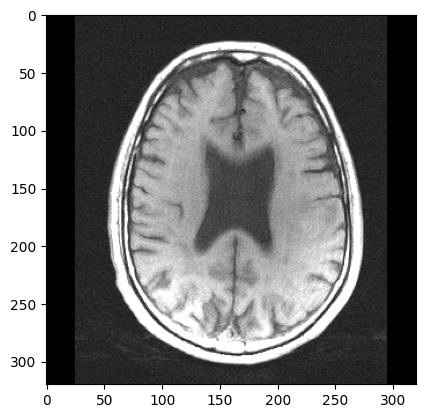

In [169]:
print(test_dataset[0])
plt.imshow(test_dataset[0]["image"].squeeze(),cmap='gray')

In [162]:
len(test_dataset)

192

In [ ]:
test_dataset.imgpaths_per_class

In [ ]:
#TODO get_image_data: implemetn s.t. classname, anomaly, etc. are gotten
#TODO get_image_data: mask_path should be NONE for good images
#TODO add neg masks later
#TODO image_name is differnet in our case. them: bottle/test/broken_large/000.png. This might cause problems later so just beware
#TODO our shape is different than in mvtec, we have grayscale images. --> 1,128,128. Plot with what's used in save-segmentation-images

MVTEC tryout

In [37]:
import os
from enum import Enum

import PIL
import torch
from torchvision import transforms

_CLASSNAMES = [
    "bottle",
    "cable",
    "capsule",
    "carpet",
    "grid",
    "hazelnut",
    "leather",
    "metal_nut",
    "pill",
    "screw",
    "tile",
    "toothbrush",
    "transistor",
    "wood",
    "zipper",
]

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


class DatasetSplit(Enum):
    TRAIN = "train"
    VAL = "val"
    TEST = "test"


class MVTecDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for MVTec.
    """

    def __init__(
        self,
        source,
        classname,
        resize=256,
        imagesize=224,
        split=DatasetSplit.TRAIN,
        train_val_split=1.0,
        **kwargs,
    ):
        """
        Args:
            source: [str]. Path to the MVTec data folder.
            classname: [str or None]. Name of MVTec class that should be
                       provided in this dataset. If None, the datasets
                       iterates over all available images.
            resize: [int]. (Square) Size the loaded image initially gets
                    resized to.
            imagesize: [int]. (Square) Size the resized loaded image gets
                       (center-)cropped to.
            split: [enum-option]. Indicates if training or test split of the
                   data should be used. Has to be an option taken from
                   DatasetSplit, e.g. mvtec.DatasetSplit.TRAIN. Note that
                   mvtec.DatasetSplit.TEST will also load mask data.
        """
        super().__init__()
        self.source = source
        self.split = split
        self.classnames_to_use = [classname] if classname is not None else _CLASSNAMES
        self.train_val_split = train_val_split

        self.imgpaths_per_class, self.data_to_iterate = self.get_image_data()

        self.transform_img = [
            transforms.Resize(resize),
            transforms.CenterCrop(imagesize),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ]
        self.transform_img = transforms.Compose(self.transform_img)

        self.transform_mask = [
            transforms.Resize(resize),
            transforms.CenterCrop(imagesize),
            transforms.ToTensor(),
        ]
        self.transform_mask = transforms.Compose(self.transform_mask)

        self.imagesize = (3, imagesize, imagesize)

        self.transform_std = IMAGENET_STD
        self.transform_mean = IMAGENET_MEAN

    def __getitem__(self, idx):
        classname, anomaly, image_path, mask_path = self.data_to_iterate[idx]
        image = PIL.Image.open(image_path).convert("RGB")
        image = self.transform_img(image)

        if self.split == DatasetSplit.TEST and mask_path is not None:
            mask = PIL.Image.open(mask_path)
            mask = self.transform_mask(mask)
        else:
            mask = torch.zeros([1, *image.size()[1:]])

        return {
            "image": image,
            "mask": mask,
            "classname": classname,
            "anomaly": anomaly,
            "is_anomaly": int(anomaly != "good"),
            "image_name": "/".join(image_path.split("/")[-4:]),
            "image_path": image_path,
        }

    def __len__(self):
        return len(self.data_to_iterate)

    def get_image_data(self):
        imgpaths_per_class = {}
        maskpaths_per_class = {}

        for classname in self.classnames_to_use:
            classpath = os.path.join(self.source, classname, self.split.value)
            maskpath = os.path.join(self.source, classname, "ground_truth")
            anomaly_types = os.listdir(classpath)

            imgpaths_per_class[classname] = {}
            maskpaths_per_class[classname] = {}

            for anomaly in anomaly_types:
                anomaly_path = os.path.join(classpath, anomaly)
                anomaly_files = sorted(os.listdir(anomaly_path))
                imgpaths_per_class[classname][anomaly] = [
                    os.path.join(anomaly_path, x) for x in anomaly_files
                ]

                if self.train_val_split < 1.0:
                    n_images = len(imgpaths_per_class[classname][anomaly])
                    train_val_split_idx = int(n_images * self.train_val_split)
                    if self.split == DatasetSplit.TRAIN:
                        imgpaths_per_class[classname][anomaly] = imgpaths_per_class[
                            classname
                        ][anomaly][:train_val_split_idx]
                    elif self.split == DatasetSplit.VAL:
                        imgpaths_per_class[classname][anomaly] = imgpaths_per_class[
                            classname
                        ][anomaly][train_val_split_idx:]

                if self.split == DatasetSplit.TEST and anomaly != "good":
                    anomaly_mask_path = os.path.join(maskpath, anomaly)
                    anomaly_mask_files = sorted(os.listdir(anomaly_mask_path))
                    maskpaths_per_class[classname][anomaly] = [
                        os.path.join(anomaly_mask_path, x) for x in anomaly_mask_files
                    ]
                else:
                    maskpaths_per_class[classname]["good"] = None

        # Unrolls the data dictionary to an easy-to-iterate list.
        data_to_iterate = []
        for classname in sorted(imgpaths_per_class.keys()):
            for anomaly in sorted(imgpaths_per_class[classname].keys()):
                for i, image_path in enumerate(imgpaths_per_class[classname][anomaly]):
                    data_tuple = [classname, anomaly, image_path]
                    if self.split == DatasetSplit.TEST and anomaly != "good":
                        data_tuple.append(maskpaths_per_class[classname][anomaly][i])
                    else:
                        data_tuple.append(None)
                    data_to_iterate.append(data_tuple)

        return imgpaths_per_class, data_to_iterate


In [41]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [42]:
%cd /content/drive/Othercomputers/My\ laptop/patchcore-medical/

/content/drive/Othercomputers/My laptop/patchcore-medical


In [43]:
root = "/content/drive/Othercomputers/My laptop/patchcore-medical/"

In [55]:
dtest_mvtec = MVTecDataset(source=root+"data/mvtec",classname="bottle",split=DatasetSplit.TEST)

In [56]:
dtest_mvtec.data_to_iterate

[['bottle',
  'broken_large',
  '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/000.png',
  '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/ground_truth/broken_large/000_mask.png'],
 ['bottle',
  'broken_large',
  '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/001.png',
  '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/ground_truth/broken_large/001_mask.png'],
 ['bottle',
  'broken_large',
  '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/002.png',
  '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/ground_truth/broken_large/002_mask.png'],
 ['bottle',
  'broken_large',
  '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/003.png',
  '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/ground_tru

In [59]:
dtest_mvtec.imgpaths_per_class

{'bottle': {'broken_large': ['/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/000.png',
   '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/001.png',
   '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/002.png',
   '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/003.png',
   '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/004.png',
   '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/005.png',
   '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/006.png',
   '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/007.png',
   '/content/drive/Othercomputers/My laptop/patchcore-medical/data/mvtec/bottle/test/broken_large/008.png',
  

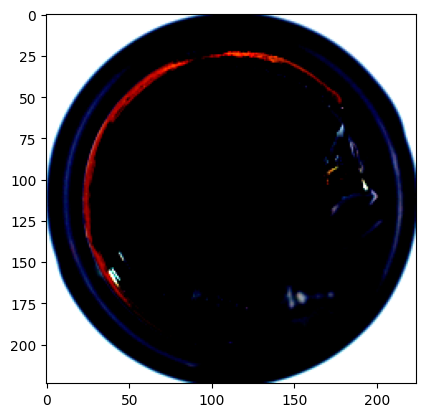

In [130]:
import matplotlib.pyplot as plt
img = dtest_mvtec[0]["image"]
# img = torch.clamp(img, 0,1)
img = img.permute(1,2,0).numpy()
plt.imshow(img)

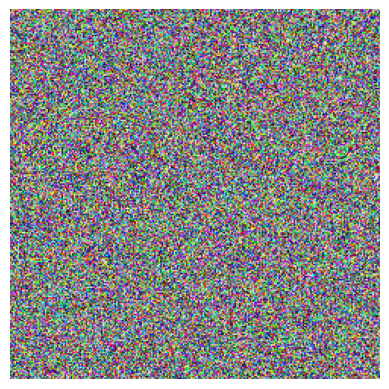

In [127]:
# Replace this with your RGB image tensor
rgb_image_tensor = torch.rand(3, 244, 244)

# Ensure values are in the valid range [0, 1]
rgb_image_tensor = torch.clamp(rgb_image_tensor, 0, 1)

# Convert the tensor to a NumPy array
rgb_image_array = rgb_image_tensor.permute(1, 2, 0).numpy()

# Display the RGB image using Matplotlib
plt.imshow(rgb_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
# imgpaths_per_class: train: {"bottle" : {"good" : [list of img_paths that are good]}}
# imgpaths_per_class: test: {"bottle" : {"good" : [list of img_paths that are good],"contamination":[list of img_paths that are contaminated]}}

#data_to_iterate: train: list of [classname,anomaly,image_path,mask_path]. mask_path = None if anomaly=good.